![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [ ]:
from AlgorithmImports import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

qb = QuantBook()

In [154]:
spy = qb.add_equity("SPY", Resolution.DAILY).symbol
history = qb.history(spy, datetime(2019, 1, 1), datetime(2024, 1, 1))

history.head()

close        high         low        open  \
symbol time                                                                  
SPY    2019-01-02 16:00:00  224.995355  225.921669  221.200166  221.290099   
       2019-01-03 16:00:00  219.626332  223.547428  219.140691  223.304607   
       2019-01-04 16:00:00  226.982883  227.630403  222.288360  222.666080   
       2019-01-07 16:00:00  228.772557  230.166525  226.362343  227.315637   
       2019-01-08 16:00:00  230.921966  231.407606  228.439804  231.002906   

                                 volume  
symbol time                              
SPY    2019-01-02 16:00:00  125704099.0  
       2019-01-03 16:00:00  133687728.0  
       2019-01-04 16:00:00  141919136.0  
       2019-01-07 16:00:00  103167903.0  
       2019-01-08 16:00:00  101633382.0

In [155]:
closes = history['close'].droplevel(0)
returns = np.log(closes / closes.shift(1)).dropna()

print(f"\nReturns statistics:")
print(f"  Mean:     {returns.mean():.6f}")
print(f"  Std:      {returns.std():.6f}")
print(f"  Skew:     {returns.skew():.4f}")
print(f"  Kurtosis: {returns.kurtosis():.4f}")  # Should be > 3


Returns statistics:
  Mean:     0.000576
  Std:      0.013281
  Skew:     -0.8213
  Kurtosis: 12.4183


In [156]:
def estimate_hurst(series, min_window=10, max_window=None):
    if isinstance(series, pd.Series):
        series = series.values
    series = np.asarray(series, dtype=np.float64)
    
    n = len(series)
    if n < 4 * min_window:
        return 0.5
    
    if max_window is None:
        max_window = n // 4
    
    mean = np.mean(series)
    y = np.cumsum(series - mean)
    
    window_sizes = []
    fluctuations = []
    
    for window in range(min_window, max_window + 1):
        n_segments = n // window
        if n_segments < 2:
            continue
            
        f2 = [] 
        for i in range(n_segments):
            start = i * window
            end = start + window
            segment = y[start:end]
            
            # Fit linear trend
            x = np.arange(window)
            coeffs = np.polyfit(x, segment, 1)
            trend = np.polyval(coeffs, x)
            
            # Compute variance of detrended segment
            detrended = segment - trend
            f2.append(np.mean(detrended ** 2))
        
        # RMS fluctuation
        fluctuation = np.sqrt(np.mean(f2))
        
        window_sizes.append(window)
        fluctuations.append(fluctuation)
    
    if len(window_sizes) < 5:
        return 0.5
    
    log_windows = np.log(window_sizes)
    log_fluct = np.log(fluctuations)
    
    slope, _, r_value, _, _ = stats.linregress(log_windows, log_fluct)
    return float(np.clip(slope, 0.0, 1.0))

In [157]:
print("HURST EXPONENT VALIDATION")
print("=" * 60)
print(f"{'Method':<25} {'Random Walk':<15} {'Trending':<15} {'Mean-Rev':<15}")
print("-" * 60)

np.random.seed(42)
n_samples = 2000

random_walk = np.random.randn(n_samples)


persistent = []
x = 0
for i in range(n_samples):
    x = 0.3 * x + np.random.randn()
    persistent.append(x)
persistent = np.cumsum(persistent)  # Integrate to get FBM-like series
persistent_returns = np.diff(persistent)

mean_rev = []
x = 0
for i in range(n_samples):
    x = -0.3 * x + np.random.randn()  # Anti-persistence
    mean_rev.append(x)
mean_rev_returns = np.array(mean_rev)

h_rs_random = estimate_hurst(random_walk)
h_rs_trend = estimate_hurst(persistent_returns)
h_rs_meanrev = estimate_hurst(mean_rev_returns)

print(f"{'R/S (DFA)':<25} {h_rs_random:<15.3f} {h_rs_trend:<15.3f} {h_rs_meanrev:<15.3f}")

print("-" * 60)
print(f"{'Expected':<25} {'~0.50':<15} {'>0.50':<15} {'<0.50':<15}")

HURST EXPONENT VALIDATION
Method                    Random Walk     Trending        Mean-Rev       
------------------------------------------------------------
R/S (DFA)                 0.519           0.536           0.477          
------------------------------------------------------------
Expected                  ~0.50           >0.50           <0.50          


In [158]:
print("\nREAL MARKET DATA (SPY)")
print("=" * 40)

h_dfa_spy = estimate_hurst(returns.values)
print(f"DFA:              H = {h_dfa_spy:.3f}")


REAL MARKET DATA (SPY)
DFA:              H = 0.427


In [159]:
# =============================================================================
# All Tail Index Estimators
# =============================================================================

def hill_estimator(sorted_abs_returns, k):
    if k < 2 or k >= len(sorted_abs_returns):
        return np.nan
    
    tail = sorted_abs_returns[:k]
    threshold = sorted_abs_returns[k]
    
    if threshold <= 0:
        return np.nan
    
    log_ratios = np.log(tail / threshold)
    log_ratios = log_ratios[log_ratios > 0]
    
    if len(log_ratios) < 2:
        return np.nan
    
    alpha = len(log_ratios) / np.sum(log_ratios)
    return alpha


def moments_estimator(sorted_abs_returns, k):
    if k < 10 or k >= len(sorted_abs_returns):
        return np.nan
    
    tail = sorted_abs_returns[:k]
    threshold = sorted_abs_returns[k]
    
    if threshold <= 0:
        return np.nan
    
    # Log excesses (same as Hill uses)
    log_excess = np.log(tail / threshold)
    log_excess = log_excess[log_excess > 0]
    
    if len(log_excess) < 5:
        return np.nan
    
    m1 = np.mean(log_excess)
    m2 = np.mean(log_excess ** 2)
    
    if m1 <= 0 or m2 <= 0:
        return np.nan
    

    # Adjusted moment estimator
    gamma = m1 + 1 - 0.5 / (1 - m1**2 / m2) if m2 > m1**2 else m1
    
    if gamma <= 0:
        return np.nan
    
    alpha = 1 / gamma
    return float(np.clip(alpha, 0.5, 6.0))


def dekkers_einmahl_dehaan_estimator(sorted_abs_returns, k):
    n = len(sorted_abs_returns)
    
    if k < 5 or k >= n:
        return np.nan
    
    tail = sorted_abs_returns[:k]
    threshold = sorted_abs_returns[k]
    
    if threshold <= 0:
        return np.nan
    
    log_excess = np.log(tail / threshold)
    log_excess = log_excess[log_excess > 0]
    
    if len(log_excess) < 5:
        return np.nan
    
    m1 = np.mean(log_excess)
    m2 = np.mean(log_excess ** 2)
    
    if m2 <= m1**2:
        return 1 / m1 if m1 > 0 else np.nan
    
    # DEH estimator
    gamma = m1 + 1 - 0.5 * (1 / (1 - m1**2 / m2))
    
    if gamma <= 0:
        return np.nan
    
    alpha = 1 / gamma
    return float(np.clip(alpha, 0.5, 6.0))

In [160]:
from scipy.stats import t as t_dist

np.random.seed(42)
n_samples = 10000

# Gaussian (thin tails, α should be high)
gaussian_samples = np.random.randn(n_samples) * 0.01


t3_samples = t_dist.rvs(df=3, size=n_samples) * 0.01  # α ≈ 3
t2_samples = t_dist.rvs(df=2, size=n_samples) * 0.01  # α ≈ 2

# Pareto/Power-law distributions with known α
def generate_pareto_tails(n, alpha_true):
    u = np.random.uniform(0.001, 1, n)
    signs = np.random.choice([-1, 1], n)
    return signs * (u ** (-1 / alpha_true)) * 0.001

pareto_15_samples = generate_pareto_tails(n_samples, alpha_true=1.5)
pareto_20_samples = generate_pareto_tails(n_samples, alpha_true=2.0)
pareto_25_samples = generate_pareto_tails(n_samples, alpha_true=2.5)

In [161]:
def estimate_tail_index_ensemble(returns, min_k_pct=5, max_k_pct=25, n_points=10):
    if isinstance(returns, pd.Series):
        returns = returns.values
    returns = np.asarray(returns, dtype=np.float64)
    
    abs_returns = np.abs(returns)
    abs_returns = abs_returns[~np.isnan(abs_returns)]
    abs_returns = abs_returns[abs_returns > 1e-10]
    
    n = len(abs_returns)
    if n < 100:
        return {
            'alpha': 2.0,
            'alpha_ci_lower': np.nan,
            'alpha_ci_upper': np.nan,
            'method': 'insufficient_data',
            'k_optimal': np.nan
        }
    
    sorted_returns = np.sort(abs_returns)[::-1]
    
    # Generate k values to test
    k_min = max(10, int(n * min_k_pct / 100))
    k_max = min(int(n * max_k_pct / 100), n // 3)
    k_values = np.linspace(k_min, k_max, n_points, dtype=int)
    
    # Collect estimates from multiple methods
    all_estimates = []
    
    for k in k_values:
        # Hill
        h = hill_estimator(sorted_returns, k)
        if not np.isnan(h) and 0.5 < h < 6:
            all_estimates.append(('hill', k, h))
        
        # DEH
        d = dekkers_einmahl_dehaan_estimator(sorted_returns, k)
        if not np.isnan(d) and 0.5 < d < 6:
            all_estimates.append(('deh', k, d))
    
    if len(all_estimates) < 5:
        return {
            'alpha': 2.0,
            'alpha_ci_lower': np.nan,
            'alpha_ci_upper': np.nan,
            'method': 'estimation_failed',
            'k_optimal': np.nan
        }
    
    alpha_values = [e[2] for e in all_estimates]
    
    hill_estimates = [(e[1], e[2]) for e in all_estimates if e[0] == 'hill']
    if len(hill_estimates) >= 3:
        hill_alphas = [e[1] for e in hill_estimates]
        
        # Use median of middle 50% as robust estimate
        q25, q75 = np.percentile(hill_alphas, [25, 75])
        middle_estimates = [a for a in hill_alphas if q25 <= a <= q75]
        
        if middle_estimates:
            hill_robust = np.median(middle_estimates)
        else:
            hill_robust = np.median(hill_alphas)
    else:
        hill_robust = np.nan
    
    # Weighted combination
    # Weight Hill more if estimates are stable (low std)
    hill_only = [e[2] for e in all_estimates if e[0] == 'hill']
    hill_std = np.std(hill_only) if len(hill_only) > 2 else np.inf
    
    if hill_std < 0.3:
        weights = {'hill': 0.6, 'pickands': 0.2, 'deh': 0.2}
    else:
        weights = {'hill': 0.34, 'pickands': 0.33, 'deh': 0.33}
    
    weighted_sum = 0
    weight_total = 0
    
    for method, k, alpha in all_estimates:
        w = weights.get(method, 0.33)
        weighted_sum += w * alpha
        weight_total += w
    
    alpha_ensemble = weighted_sum / weight_total if weight_total > 0 else np.median(alpha_values)
    
    n_boot = 200
    boot_alphas = []
    
    for _ in range(n_boot):
        boot_idx = np.random.choice(n, size=n, replace=True)
        boot_sample = np.sort(abs_returns[boot_idx])[::-1]
        
        k_mid = k_values[len(k_values) // 2]
        boot_alpha = hill_estimator(boot_sample, k_mid)
        
        if not np.isnan(boot_alpha) and 0.5 < boot_alpha < 6:
            boot_alphas.append(boot_alpha)
    
    if len(boot_alphas) > 20:
        ci_lower = np.percentile(boot_alphas, 5)
        ci_upper = np.percentile(boot_alphas, 95)
    else:
        ci_lower = ci_upper = np.nan
    
    return {
        'alpha': float(alpha_ensemble),
        'alpha_ci_lower': float(ci_lower),
        'alpha_ci_upper': float(ci_upper),
        'hill_robust': float(hill_robust) if not np.isnan(hill_robust) else None,
        'n_estimates': len(all_estimates),
        'hill_std': float(hill_std),
        'method': 'ensemble',
        'k_range': (int(k_min), int(k_max))
    }

In [162]:
print("ENSEMBLE TAIL ESTIMATOR VALIDATION")
print("=" * 75)
print(f"{'Distribution':<20} {'True α':<10} {'Est α':<10} {'95% CI':<20} {'Status'}")
print("-" * 75)

test_cases = [
    ("Gaussian", gaussian_samples, ">3.0", None),
    ("Student t (df=3)", t3_samples, "≈3.0", 3.0),
    ("Student t (df=2)", t2_samples, "≈2.0", 2.0),
    ("Pareto α=1.5", pareto_15_samples, "≈1.5", 1.5),
    ("Pareto α=2.0", pareto_20_samples, "≈2.0", 2.0),
    ("Pareto α=2.5", pareto_25_samples, "≈2.5", 2.5),
]

for name, samples, expected_str, true_alpha in test_cases:
    result = estimate_tail_index_ensemble(samples)
    alpha = result['alpha']
    ci_low = result['alpha_ci_lower']
    ci_high = result['alpha_ci_upper']
    
    ci_str = f"[{ci_low:.2f}, {ci_high:.2f}]" if not np.isnan(ci_low) else "N/A"
    
    # Check accuracy
    if true_alpha is not None:
        error = abs(alpha - true_alpha) / true_alpha * 100
        if error < 15:
            status = "✓"
        elif error < 25:
            status = "~"
        else:
            status = "✗"
        status += f" ({error:.0f}% err)"
    else:
        status = "✓" if alpha > 3.0 else "✗"
    
    print(f"{name:<20} {expected_str:<10} {alpha:<10.3f} {ci_str:<20} {status}")

print("-" * 75)

ENSEMBLE TAIL ESTIMATOR VALIDATION
Distribution         True α     Est α      95% CI               Status
---------------------------------------------------------------------------
Gaussian             >3.0       3.964      [3.72, 3.98]         ✓
Student t (df=3)     ≈3.0       2.582      [2.17, 2.34]         ✓ (14% err)
Student t (df=2)     ≈2.0       1.841      [1.72, 1.86]         ✓ (8% err)
Pareto α=1.5         ≈1.5       1.592      [1.50, 1.63]         ✓ (6% err)
Pareto α=2.0         ≈2.0       2.205      [2.02, 2.17]         ✓ (10% err)
Pareto α=2.5         ≈2.5       2.794      [2.46, 2.66]         ✓ (12% err)
---------------------------------------------------------------------------


In [163]:
print("\nREAL MARKET DATA - SPY")
print("=" * 75)

result_spy = estimate_tail_index_ensemble(returns.values)

print(f"Tail Index (α):     {result_spy['alpha']:.3f}")
print(f"90% CI:             [{result_spy['alpha_ci_lower']:.3f}, {result_spy['alpha_ci_upper']:.3f}]")
print(f"Hill robust est:    {result_spy['hill_robust']:.3f}" if result_spy['hill_robust'] else "Hill robust est: N/A")
print(f"Hill stability:     {'Good' if result_spy['hill_std'] < 0.3 else 'Moderate' if result_spy['hill_std'] < 0.5 else 'Poor'} (std={result_spy['hill_std']:.3f})")
print(f"k range used:       {result_spy['k_range']}")
print(f"# estimates:        {result_spy['n_estimates']}")


REAL MARKET DATA - SPY
Tail Index (α):     2.511
90% CI:             [2.066, 2.556]
Hill robust est:    2.299
Hill stability:     Good (std=0.160)
k range used:       (62, 313)
# estimates:        20


In [164]:
def compute_realized_vol(prices, window=20):
    if isinstance(prices, np.ndarray):
        prices = pd.Series(prices)
    
    log_returns = np.log(prices / prices.shift(1))
    return log_returns.rolling(window).std() * np.sqrt(252)

def compute_vol_of_vol(realized_vol, window=20):
    return realized_vol.rolling(window).std()


def compute_vol_regime(realized_vol, short_window=10, long_window=60):
    short_vol = realized_vol.rolling(short_window).mean()
    long_vol = realized_vol.rolling(long_window).mean()
    
    return short_vol / long_vol

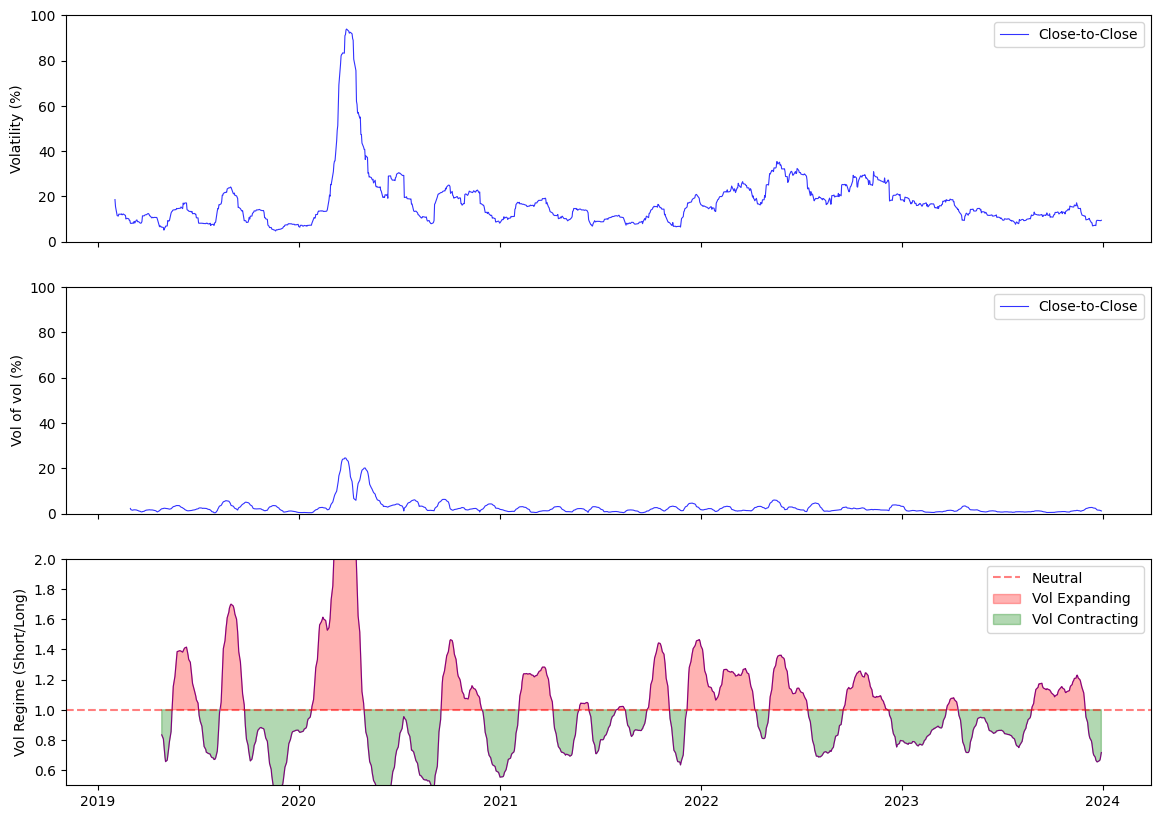

In [165]:
# =============================================================================
# Visualize Volatility Measures
# =============================================================================    
log_returns = np.log(closes / closes.shift(1))
realized_vol = log_returns.rolling(20).std() * np.sqrt(252)

vol_short = realized_vol.rolling(10).mean()
vol_long = realized_vol.rolling(60).mean()
vol_regime = vol_short / vol_long
vol_of_vol = compute_vol_of_vol(realized_vol, window=20)


fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)


ax1 = axes[0]
ax1.plot(realized_vol.index, realized_vol.values * 100, 'b-', linewidth=0.8, label='Close-to-Close', alpha=0.8)
ax1.set_ylabel('Volatility (%)')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 100)

ax1 = axes[1]
ax1.plot(vol_of_vol.index, vol_of_vol.values * 100, 'b-', linewidth=0.8, label='Close-to-Close', alpha=0.8)
ax1.set_ylabel('Vol of vol (%)')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 100)

ax2 = axes[2]
ax2.plot(vol_regime.index, vol_regime.values, 'purple', linewidth=0.8)
ax2.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Neutral')
ax2.fill_between(vol_regime.index, 1.0, vol_regime.values,
                 where=vol_regime.values > 1.0, alpha=0.3, color='red', label='Vol Expanding')
ax2.fill_between(vol_regime.index, 1.0, vol_regime.values,
                 where=vol_regime.values < 1.0, alpha=0.3, color='green', label='Vol Contracting')
ax2.set_ylabel('Vol Regime (Short/Long)')
ax2.set_ylim(0.5, 2.0)
ax2.legend(loc='upper right')

In [166]:
from AlgorithmImports import *
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

qb = QuantBook()

spy = qb.add_equity("SPY", Resolution.DAILY)
spy.set_data_normalization_mode(DataNormalizationMode.RAW)
spy_option = qb.add_option("SPY", Resolution.DAILY)
spy_option.set_filter(lambda u: u.include_weeklys().strikes(-5, 5).expiration(7, 60))

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 6, 1)

spy_history = qb.history(spy.symbol, start_date, end_date, Resolution.DAILY)
spy_closes = spy_history['close'].droplevel(0)

print(f"SPY data: {len(spy_closes)} days")

SPY data: 103 days


In [167]:
option_history = qb.option_history(
    spy.symbol,
    start_date,
    end_date,
    Resolution.DAILY
)

option_df = option_history.get_all_data()

print(f"Original shape: {option_df.shape}")
print(f"Index names: {option_df.index.names}")

df = option_df.reset_index()
spy_closes.index = pd.to_datetime(spy_closes.index).normalize()

print(f"\nAfter reset_index:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Original shape: (90421, 15)
Index names: ['expiry', 'strike', 'type', 'symbol', 'time']

After reset_index:
Shape: (90421, 20)
Columns: ['expiry', 'strike', 'type', 'symbol', 'time', 'askclose', 'askhigh', 'asklow', 'askopen', 'asksize', 'bidclose', 'bidhigh', 'bidlow', 'bidopen', 'bidsize', 'close', 'high', 'low', 'open', 'volume']


In [168]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price."""
    if T <= 0 or sigma <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price


def implied_volatility(option_price, S, K, T, r, option_type='call'):
    if T <= 0 or option_price <= 0:
        return np.nan
    
    # Intrinsic value
    if option_type == 'call':
        intrinsic = max(S - K * np.exp(-r * T), 0)
    else:
        intrinsic = max(K * np.exp(-r * T) - S, 0)
    
    if option_price < intrinsic * 0.99:  # Allow small buffer
        return np.nan
    
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - option_price
    
    try:
        iv = brentq(objective, 0.01, 3.0, maxiter=100)
        return iv
    except (ValueError, RuntimeError):
        return np.nan

print("Black-Scholes Test:")
test_price = black_scholes_price(400, 400, 30/365, 0.05, 0.20, 'call')
test_iv = implied_volatility(test_price, 400, 400, 30/365, 0.05, 'call')
print(f"  Price at 20% vol: ${test_price:.2f}")
print(f"  Recovered IV: {test_iv:.1%}")

Black-Scholes Test:
  Price at 20% vol: $9.97
  Recovered IV: 20.0%


In [169]:
def extract_atm_iv(df, underlying_prices, risk_free_rate=0.05):
    """Extract ATM IV for each trading day."""
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['trade_date'] = df['time'].dt.normalize()
    df['expiry'] = pd.to_datetime(df['expiry'])
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')
    df['mid_price'] = (df['bidclose'] + df['askclose']) / 2
    
    daily_iv = {}
    
    # Get common dates
    option_dates = set(df['trade_date'].unique())
    underlying_dates = set(underlying_prices.index)
    common_dates = sorted(option_dates & underlying_dates)
    
    print(f"Processing {len(common_dates)} dates...")
    
    for i, date in enumerate(common_dates):
        spot = underlying_prices.loc[date]
        day_opts = df[df['trade_date'] == date].copy()
        
        day_opts['T'] = (day_opts['expiry'] - date).dt.days / 365.0
        day_opts['moneyness'] = abs(day_opts['strike'] - spot) / spot
        
        # Filter
        valid = day_opts[
            (day_opts['bidclose'] > 0) &
            (day_opts['mid_price'] > 0.10) &
            (day_opts['T'] > 0.02) &
            (day_opts['T'] < 0.20)
        ]
        
        atm = valid[valid['moneyness'] < 0.05]
        if len(atm) == 0:
            atm = valid.nsmallest(6, 'moneyness')
        
        if len(atm) == 0:
            continue
        
        # Calculate IVs
        ivs = []
        for _, row in atm.iterrows():
            opt_type = 'call' if 'Call' in str(row['type']) else 'put'
            iv = implied_volatility(row['mid_price'], spot, row['strike'], row['T'], risk_free_rate, opt_type)
            if not np.isnan(iv) and 0.05 < iv < 1.5:
                ivs.append(iv)
        
        if ivs:
            daily_iv[date] = np.median(ivs)
    
    print(f"Extracted IV for {len(daily_iv)} days")
    return pd.Series(daily_iv).sort_index()


atm_iv = extract_atm_iv(df, spy_closes)

print(f"\nIV Statistics:")
print(f"  Count: {len(atm_iv)}")
print(f"  Mean:  {atm_iv.mean():.1%}")
print(f"  Min:   {atm_iv.min():.1%}")
print(f"  Max:   {atm_iv.max():.1%}")

Processing 103 dates...
Extracted IV for 103 days

IV Statistics:
  Count: 103
  Mean:  17.9%
  Min:   13.6%
  Max:   24.6%


IV/RV RATIO
Mean:   1.167
Median: 1.138
Min:    0.903
Max:    1.685


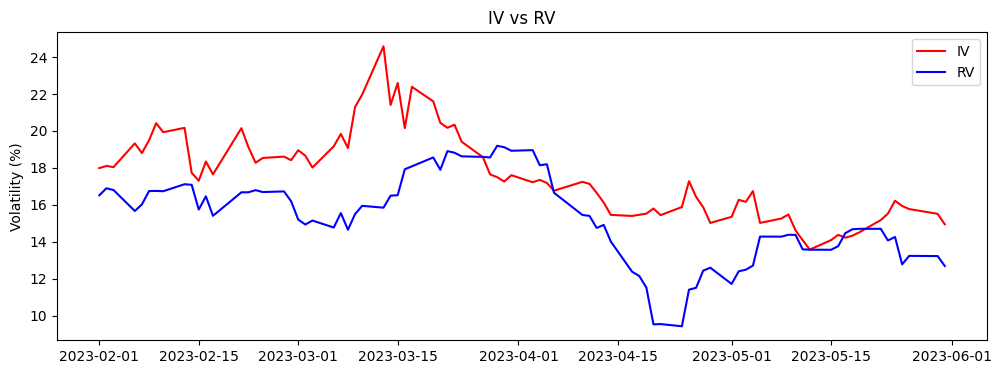

In [170]:
# =============================================================================
# CELL 10: Compute IV/RV Ratio
# =============================================================================

if len(atm_iv) > 0:
    # Realized vol
    log_returns = np.log(spy_closes / spy_closes.shift(1))
    realized_vol = log_returns.rolling(20).std() * np.sqrt(252)
    
    # Align
    common = atm_iv.index.intersection(realized_vol.dropna().index)
    
    iv = atm_iv.loc[common]
    rv = realized_vol.loc[common]
    iv_rv_ratio = iv / rv
    
    print("IV/RV RATIO")
    print("=" * 40)
    print(f"Mean:   {iv_rv_ratio.mean():.3f}")
    print(f"Median: {iv_rv_ratio.median():.3f}")
    print(f"Min:    {iv_rv_ratio.min():.3f}")
    print(f"Max:    {iv_rv_ratio.max():.3f}")
    
    # Quick plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(iv.index, iv * 100, 'r-', label='IV')
    ax.plot(rv.index, rv * 100, 'b-', label='RV')
    ax.set_ylabel('Volatility (%)')
    ax.legend()
    ax.set_title('IV vs RV')
    plt.show()

In [171]:
def compute_iv_rv_ratio(option_df, underlying_prices, rv_window=20, risk_free_rate=0.05):
    iv_series = extract_atm_iv(option_df, underlying_prices, risk_free_rate)
    
    log_returns = np.log(underlying_prices / underlying_prices.shift(1))
    rv_series = log_returns.rolling(rv_window).std() * np.sqrt(252)
    
    # Align dates
    common = iv_series.index.intersection(rv_series.dropna().index)
    
    result = pd.DataFrame({
        'iv': iv_series.loc[common],
        'rv': rv_series.loc[common]
    })
    result['iv_rv_ratio'] = result['iv'] / result['rv']
    
    return result


iv_rv_df = compute_iv_rv_ratio(df, spy_closes)

print("IV/RV DataFrame Summary:")
print(iv_rv_df.describe().round(3))

Processing 103 dates...
Extracted IV for 103 days
IV/RV DataFrame Summary:
           iv      rv  iv_rv_ratio
count  83.000  83.000       83.000
mean    0.176   0.153        1.167
std     0.023   0.024        0.165
min     0.136   0.094        0.903
25%     0.155   0.137        1.059
50%     0.173   0.154        1.138
75%     0.191   0.167        1.248
max     0.246   0.192        1.685


In [ ]:
# =============================================================================
# Final Multifractal Width Function for Strategy
# =============================================================================

def compute_mf_width(returns, min_points=50):
    if isinstance(returns, pd.Series):
        returns = returns.values
    returns = np.asarray(returns, dtype=np.float64)
    returns = returns[~np.isnan(returns)]
    
    n = len(returns)
    if n < min_points:
        return np.nan
    
    # Integrate series
    profile = np.cumsum(returns - np.mean(returns))
    
    # Scales
    max_scale = n // 4
    min_scale = 4
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 12).astype(int))
    
    def get_hurst_at_q(q):
        log_scales = []
        log_Fq = []
        
        for scale in scales:
            n_segments = n // scale
            if n_segments < 2:
                continue
            
            variances = []
            for i in range(n_segments):
                segment = profile[i * scale:(i + 1) * scale]
                x = np.arange(len(segment))
                trend = np.polyval(np.polyfit(x, segment, 1), x)
                var = np.mean((segment - trend) ** 2)
                if var > 0:
                    variances.append(var)
            
            if len(variances) < 2:
                continue
            
            variances = np.array(variances)
            if q < 0:
                variances = np.clip(variances, 1e-20, None)
            
            Fq = np.mean(variances ** (q / 2)) ** (1 / q)
            
            if Fq > 0 and np.isfinite(Fq):
                log_scales.append(np.log(scale))
                log_Fq.append(np.log(Fq))
        
        if len(log_scales) >= 3:
            slope, _, r_value, _, _ = stats.linregress(log_scales, log_Fq)
            if r_value ** 2 > 0.5:
                return slope
        return np.nan
    
    h_low = get_hurst_at_q(0.5)
    h_high = get_hurst_at_q(3)
    
    if np.isfinite(h_low) and np.isfinite(h_high):
        return abs(h_low - h_high)
    return np.nan


# Quick test
returns = np.log(spy_closes / spy_closes.shift(1)).dropna()
width = compute_mf_width(returns.values)
print(f"H(q=0.5): {result['h_low']:.4f}" if not np.isnan(result['h_low']) else "H(q=0.5): N/A")
print(f"H(q=3):   {result['h_high']:.4f}" if not np.isnan(result['h_high']) else "H(q=3): N/A")
print(f"Width:    {result['width']:.4f}" if not np.isnan(result['width']) else "Width: N/A")
print(f"SPY Multifractal Width: {width:.4f}")

H(q=0.5): 0.4922
H(q=3):   0.3671
Width:    0.1251
SPY Multifractal Width: 0.1251
